## Get data

In [1]:
import pandas as pd
import warnings
from utils.mt_5.data import get_currency_pair_data_

warnings.filterwarnings('ignore')

df = get_currency_pair_data_("USDCAD", timeframe="M30", years_back=.08)
df

,close
time,
2024-10-23 09:00:00,1.38196
2024-10-23 09:30:00,1.38230
2024-10-23 10:00:00,1.38198
2024-10-23 10:30:00,1.38235
2024-10-23 11:00:00,1.38236
...,...
2024-12-03 12:30:00,1.40197
2024-12-03 13:00:00,1.40266
2024-12-03 13:30:00,1.40370


## Model trend

In [2]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

dp = DeterministicProcess(index=df.index, order=1, constant=True, drop=True)

X = dp.in_sample()
y = df['close']

y, X = y.align(X, join='inner')

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

time
2024-10-23 09:00:00    1.385460
2024-10-23 09:30:00    1.385475
2024-10-23 10:00:00    1.385489
2024-10-23 10:30:00    1.385503
2024-10-23 11:00:00    1.385518
                         ...   
2024-12-03 12:30:00    1.405511
2024-12-03 13:00:00    1.405525
2024-12-03 13:30:00    1.405539
2024-12-03 14:00:00    1.405554
2024-12-03 14:30:00    1.405568
Length: 1402, dtype: float64

<Axes: xlabel='time'>

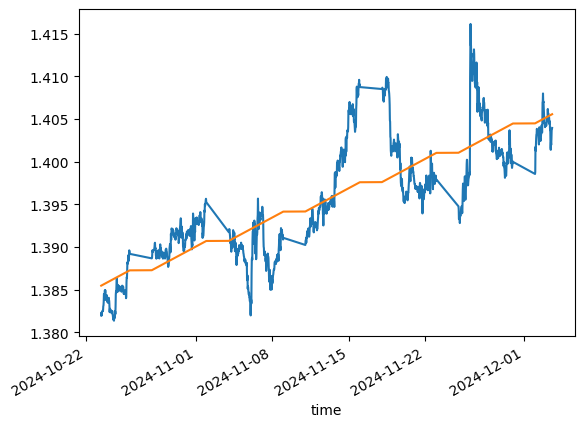

In [3]:
df['close'].plot()
y_pred.plot()

## Forecast

In [4]:
X_ = dp.out_of_sample(10)
X_dates = pd.date_range(start=X.index[-1], periods=len(X_), freq=pd.Timedelta(minutes=30))

y_fore = pd.Series(model.predict(X_), index=X_.index)

forecast_df = pd.DataFrame(y_fore)
forecast_df.index = X_dates

forecast_df.columns = ['predicted_close']
forecast_df

,predicted_close
2024-12-03 14:30:00,1.405582
2024-12-03 15:00:00,1.405597
2024-12-03 15:30:00,1.405611
2024-12-03 16:00:00,1.405625
2024-12-03 16:30:00,1.405640
2024-12-03 17:00:00,1.405654
2024-12-03 17:30:00,1.405669
2024-12-03 18:00:00,1.405683
2024-12-03 18:30:00,1.405697
2024-12-03 19:00:00,1.405712


In [5]:
current_price = df['close'].iloc[-1] 
predicted_day_close = round(forecast_df['predicted_close'].iloc[-1], 5) 

threshold = 0.001  

if predicted_day_close > current_price: # buy
    print("predicted_day_close is GREATER than current_close")
    target_profit = round((predicted_day_close - current_price) * 10000)

if predicted_day_close < current_price: # short-sell
    print("We will close LOWER!")
    target_profit = round((current_price - predicted_day_close) * 10000)
    


print(current_price, predicted_day_close, target_profit)

predicted_day_close is GREATER than current_close
1.40396 1.40571 17


## Trade

In [6]:
from utils.mt_5.trade import buy, short_sell, sell

symbol = "USDCAD"  

current_price = df['close'].iloc[-1] 
predicted_day_close = round(forecast_df['predicted_close'].iloc[-1], 5) 

threshold = 0.001  

if predicted_day_close > current_price: # buy
    print("predicted_day_close is GREATER than current_close\n....BUYING....")
    target_profit = round((predicted_day_close - current_price) * 10000)
    buy(symbol, target_profit=target_profit)

elif predicted_day_close < current_price: # short-sell
    print("We will close LOWER!\n.....SHORT-SELLING.....")
    target_profit = round((current_price - predicted_day_close) * 10000)
    short_sell(symbol, target_profit=target_profit)

elif df.index.time[-1] >= pd.Timestamp('20:00:00').time():
    sell(symbol)
else:
    print("....I DON'T KNOW HOW TO HELP YOU!....")



predicted_day_close is GREATER than current_close
....BUYING....
USDCADm already bought!


(                       close        day
 time                                   
 2023-10-03 03:00:00  1.37087    Tuesday
 2023-10-04 03:00:00  1.37437  Wednesday
 2023-10-05 03:00:00  1.37062   Thursday
 2023-10-06 03:00:00  1.36613     Friday
 2023-10-09 03:00:00  1.35796     Monday
 ...                      ...        ...
 2024-11-27 03:00:00  1.40254  Wednesday
 2024-11-28 03:00:00  1.40073   Thursday
 2024-11-29 03:00:00  1.39998     Friday
 2024-12-02 03:00:00  1.40457     Monday
 2024-12-03 03:00:00  1.40380    Tuesday
 
 [306 rows x 2 columns],
 <Axes: xlabel='day', ylabel='close'>)

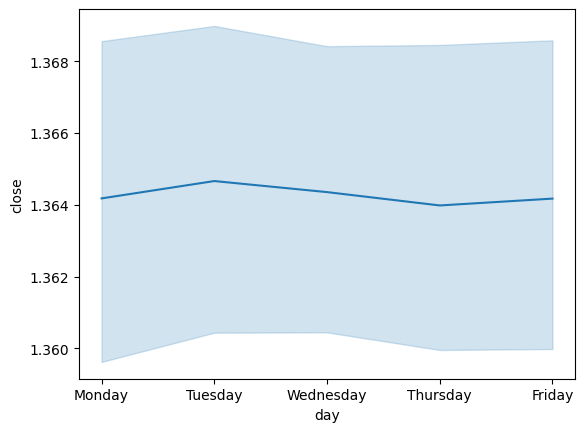

In [8]:
from models.seasonality.weekly import daily

daily(symbol)

(                       close       session
 time                                      
 2024-03-22 03:00:00  1.35220   Tokyo(0300)
 2024-03-22 04:00:00  1.35448   Tokyo(0300)
 2024-03-22 05:00:00  1.35585   Tokyo(0300)
 2024-03-22 06:00:00  1.35605   Tokyo(0300)
 2024-03-22 07:00:00  1.35598   Tokyo(0300)
 ...                      ...           ...
 2024-11-30 00:00:00  1.39998  Sydney(2200)
 2024-12-02 01:00:00  1.39880  Sydney(2200)
 2024-12-02 02:00:00  1.40127  Sydney(2200)
 2024-12-02 22:00:00  1.40452  Sydney(2200)
 2024-12-02 23:00:00  1.40451  Sydney(2200)
 
 [3640 rows x 2 columns],
 <Axes: xlabel='session', ylabel='close'>)

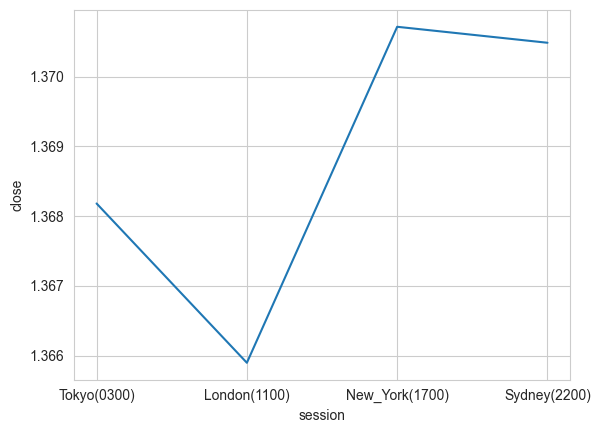

In [9]:
from models.seasonality.sessional import hourly

hourly(symbol)